<a href="https://colab.research.google.com/github/mofuoku417/Univariate_Crude_Palm_Oil_Price_Prediction/blob/main/Crude_PalmOil_Price_Prediction_SARIMA_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Install the Preliminaries

In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 66.1 MB/s eta 0:00:00


###Load Basic Libraries

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.api import (kpss, adfuller, seasonal_decompose, STL)
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import pmdarima as pm
from math import sqrt
from pathlib import Path
from pandas import read_csv
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5]
import os
import matplotlib 
import scipy 
import sklearn

In [16]:
#Applying configurations for the quality of the image
plt.rcParams["figure.figsize"] = [12, 5]            
#plt.rcParams['figure.dpi'] = 100                  
plt.rc('font', size=8)                             
plt.rc('axes', titlesize=14)                       
plt.rc('axes', labelsize=14)                       
plt.rc('xtick', labelsize=10)                      
plt.rc('ytick', labelsize=10)                      
plt.rc('legend', fontsize=10)                      


In [17]:
#Read our data
path = 'https://raw.githubusercontent.com/mofuoku417/Univariate_Crude_Palm_Oil_Price_Prediction/main/Data/data.csv'
df = read_csv(path, parse_dates=True)
#df = read_csv(path,index_col='Month', parse_dates=True)
df.head()

,Month,Price,Change
0,1993-03,408,-
1,1993-04,392,-3.92%
2,1993-05,371,-5.36%
3,1993-06,356,-4.04%
4,1993-07,362,1.69%




*   Our data first column is Month, so we need to rename it to date
*   The second column is price, so we rename to cpo_pri (crude palm oil price)



In [18]:
#renaming Month column to date
df.rename(columns={'Month': 'date', 'Price': 'cpo_pri'}, inplace=True)
df.head()

,date,cpo_pri,Change
0,1993-03,408,-
1,1993-04,392,-3.92%
2,1993-05,371,-5.36%
3,1993-06,356,-4.04%
4,1993-07,362,1.69%




*   We remove the Change column because it is not needed



In [19]:
#Delete change column
del df['Change']



*   Convert the date from object to datetime




In [20]:
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361 entries, 0 to 360
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     361 non-null    datetime64[ns]
 1   cpo_pri  361 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 5.8+ KB


In [21]:
# Change the data index from string to date
df.set_index('date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 361 entries, 1993-03-01 to 2023-03-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   cpo_pri  361 non-null    object
dtypes: object(1)
memory usage: 5.6+ KB




*  We need to remove commas from the dataframe
*  We also need to change the type of cpo_pri from object to float



In [22]:
#Remove the commas from the data
df["cpo_pri"] = [float(str(i).replace(",", "")) for i in df["cpo_pri"]]

df.dtypes

cpo_pri    float64
dtype: object

Plot the Data

<Axes: xlabel='date'>

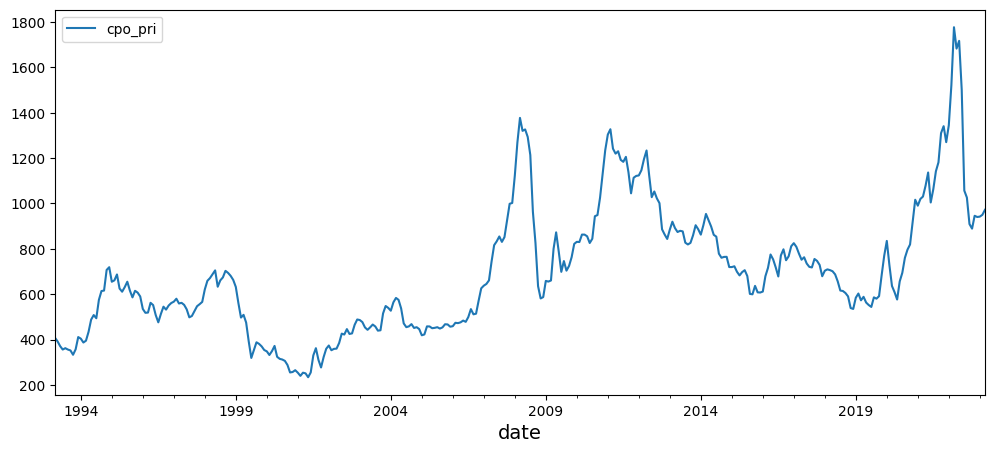

In [23]:
df.plot()

In [11]:
'''
import plotly.io as pio
pio.renderers.default = "colab"
df.iplot(title="Monthly Crude Palm Oil Price Between March 1993 to March 2023")
'''

'\nimport plotly.io as pio\npio.renderers.default = "colab"\ndf.iplot(title="Monthly Crude Palm Oil Price Between March 1993 to March 2023")\n'

###Decompose the Time-Series

We'll need to break down our time series into three parts: seasonal, trend, and residual. There are other approaches, but the simplest is to use statsmodels.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

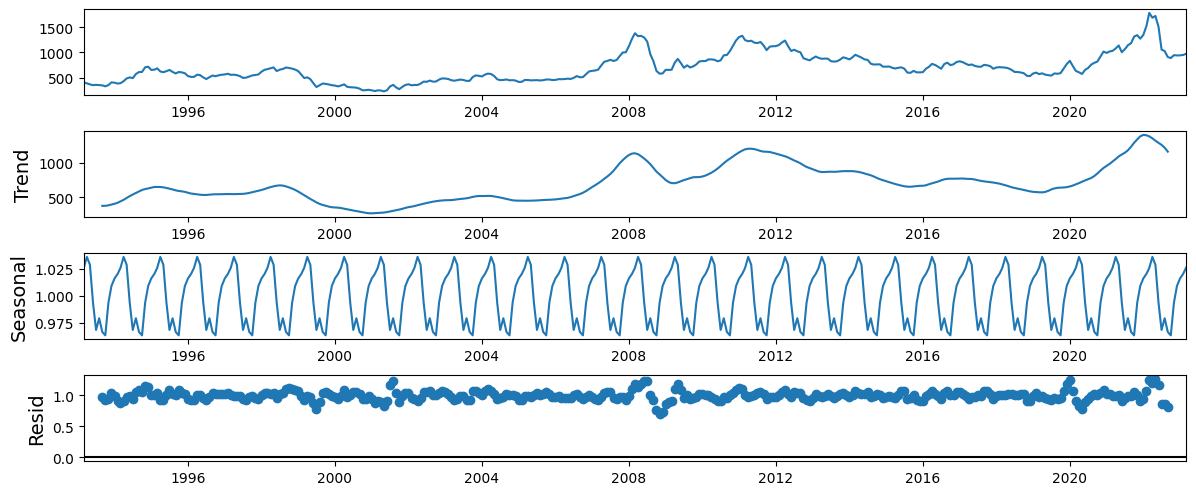

In [25]:
#Statsmodels will be applied to decompose this time series
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='multiplicative')

fig = result.plot()

The plot itself demonstrates that our time series contains a 'seasonal' component

The Augmented Dickey Fuller (ADF) test may also be used to determine the time series' stationarity.

In [26]:
result=adfuller(df.cpo_pri.dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')

ADF Statistics:-2.203015257570212
p-value:0.2051529130569439


The p-value is greater than or equal to 0.05. This indicates that the time series is nonstationary with a 95% confidence level 

In [27]:
result=adfuller(df.cpo_pri.diff().dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')

ADF Statistics:-4.97886807260988
p-value:2.4432579033101085e-05


With a 1-order difference, the series now seems stationary.

In [55]:
#2.4432579033101085e-05 > 0.05

False

###Split time series data into training and test set



*   For the Test, we'll need to remove a section of our most recent data, say from January of 2016.
*   After splitting up the test section, we'll train on the remaining data.



In [28]:
#Splitting the data

def split_data(data, test_split):
    l = len(data)
    t_idx = round(l*(1-test_split))
    train, test = data[ : t_idx], data[t_idx : ]
    print(f'train: {len(train)} , test: {len(test)}')
    return train, test

In [29]:
test_split = 0.15
df_train, df_test = split_data(df, test_split)

train: 307 , test: 54


In [31]:
df_pred = df_train.iloc[-54:]

df_pred

,cpo_pri
date,
2014-04-01,926.63
2014-05-01,898.42
2014-06-01,861.88
2014-07-01,853.69
2014-08-01,778.69
2014-09-01,760.75
2014-10-01,764.40
2014-11-01,764.75
2014-12-01,719.64


In [17]:
df_train #1993-03-01 to 2018-09-01
print(len(df_train))

307


In [18]:
df_test  #2020-09-01 to 2023-03-01
print(len(df_test))

54


In [32]:
#Checking for stationarity
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

In [33]:
# Getting the AIC score
def get_best_model(score, c='AIC'):
    initial_score = score[0][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score = v[c]
            best_model = k
    print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
    return score[best_model]['model']

In [34]:
def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]), 
                            index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    # plt.show()
    return ax

In [35]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]
    return combo

###Plotting the ACF and PACF

<Axes: xlabel='date'>

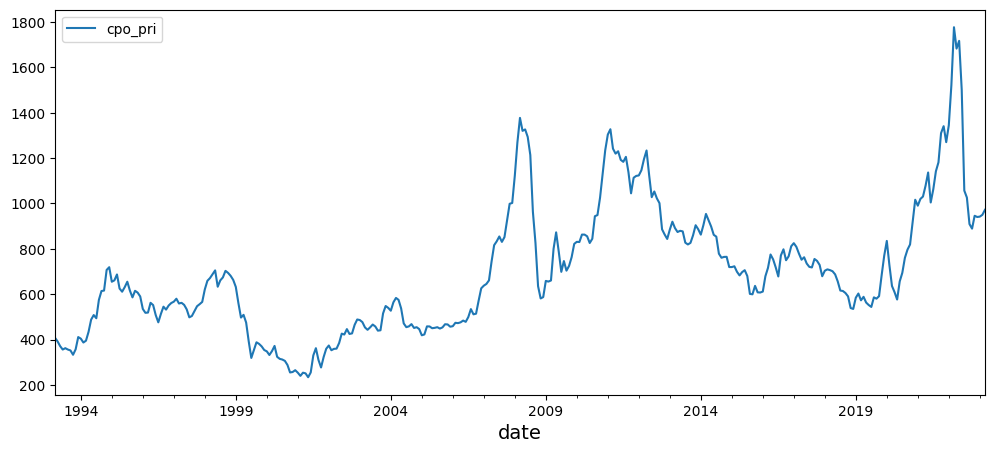

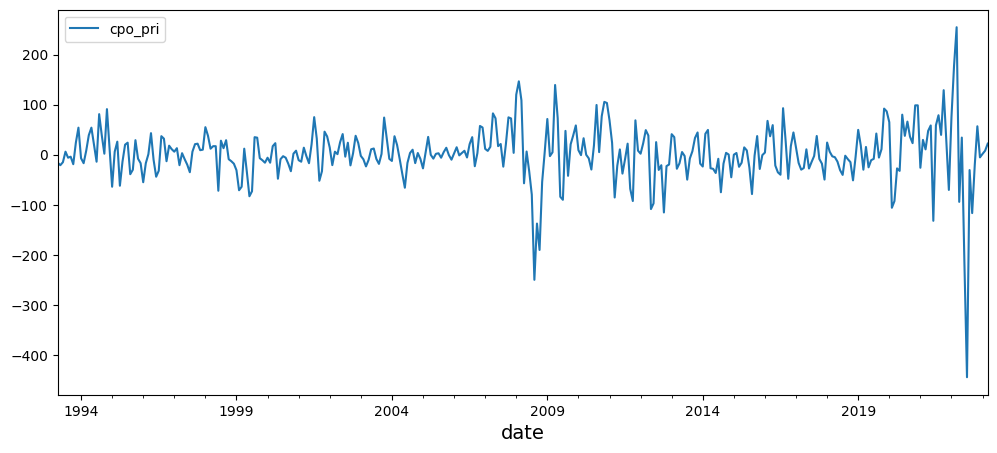

In [36]:
# plt.rcParams["figure.figsize"] = [16, 4]
df.plot()
life_diff = df.diff().dropna()
life_diff.plot()

In [17]:
#Checking for stationarity
#check_stationarity(life_diff)

'Stationary	 p-value:2.4432579033101085e-05 	 lags:15


('Stationary', 2.4432579033101085e-05)

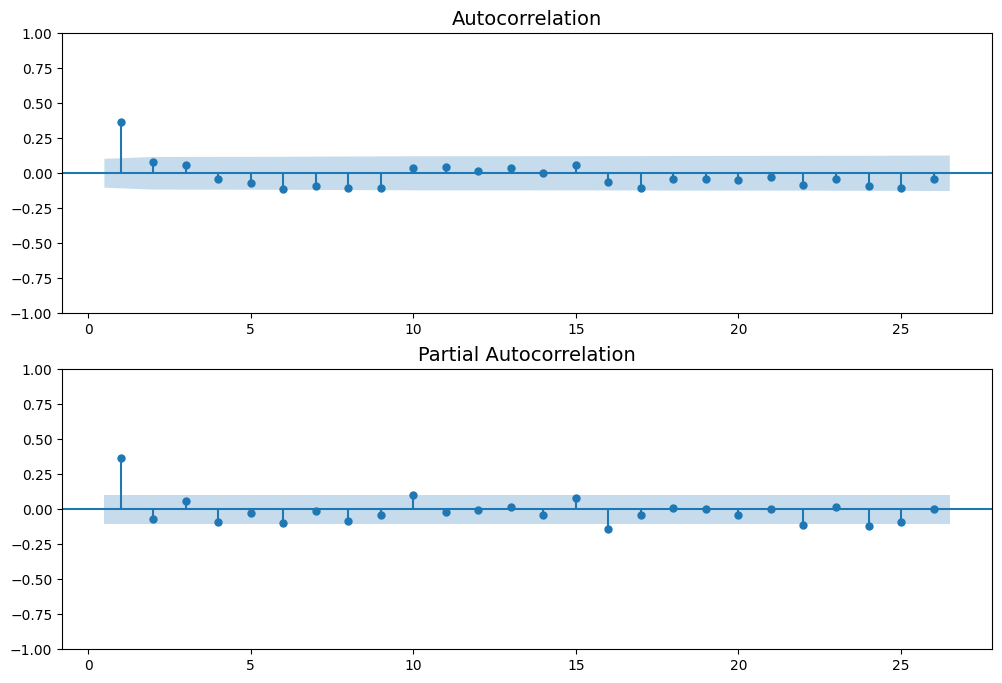

In [37]:
#Plotting the autocorrelation
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(life_diff, zero=False, ax=ax[0])
plot_pacf(life_diff, zero=False, ax=ax[1])
#plt.savefig('images/fig_10.2.png', bbox_inches='tight', dpi=300)
plt.show()

##SARIMAX Model

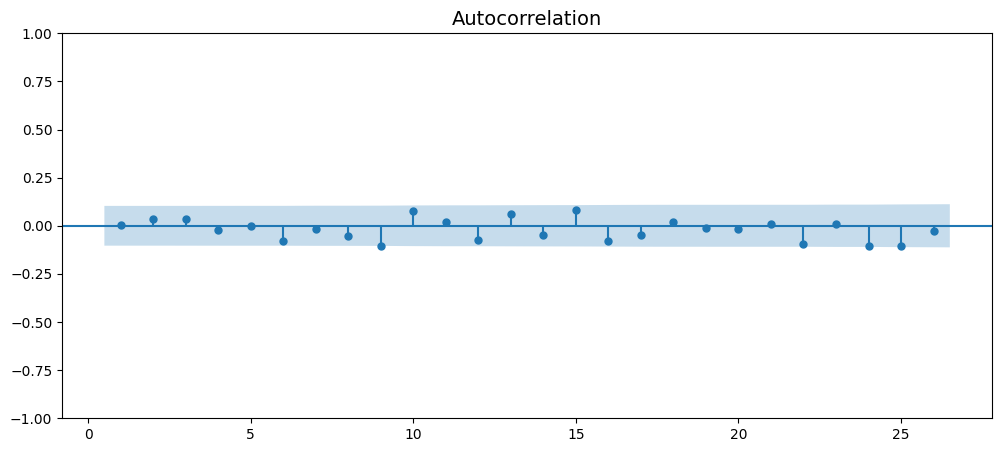

In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df, order=(0,1,1),
                seasonal_order=(0,1,1, 12)).fit(disp=False)
plot_acf(model.resid[1:], zero=False)
plt.show()

<Axes: xlabel='date'>

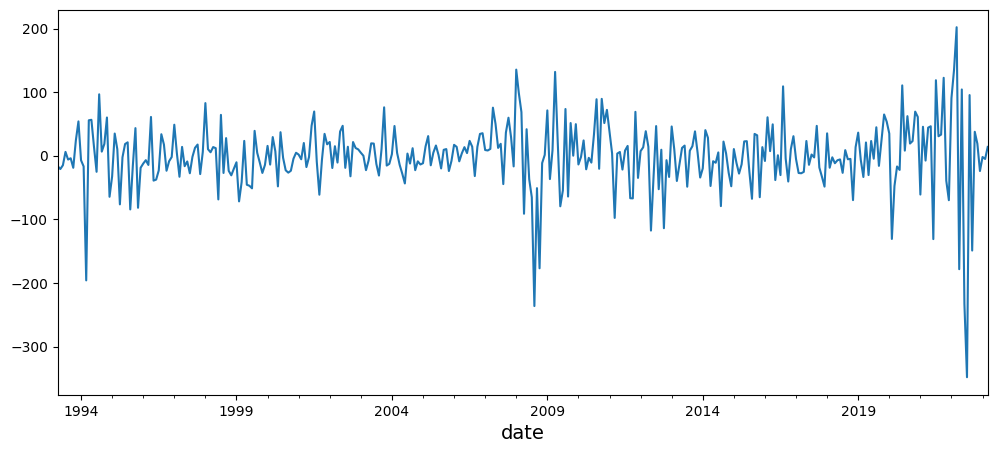

In [24]:
#Plot the residual
model.resid[1:].plot()

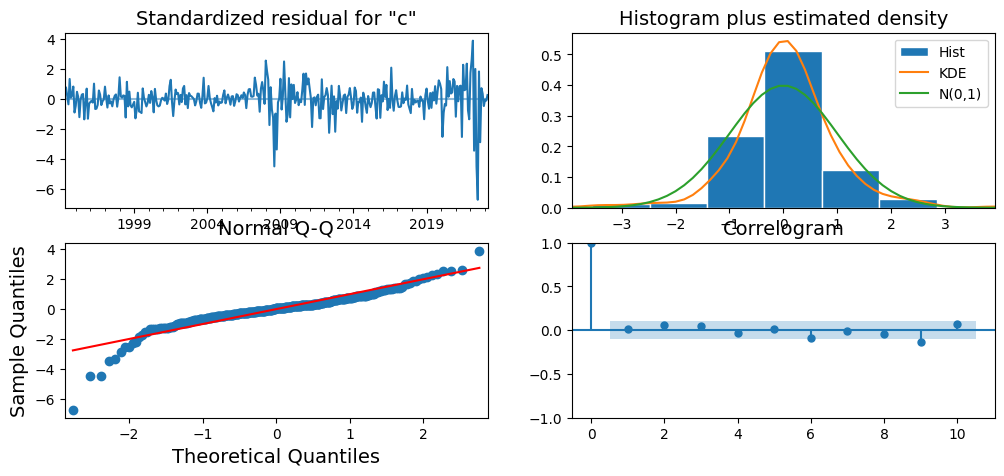

In [25]:
#Plotting the model diagnostics
model.plot_diagnostics();

###Auto ARIMA

In [39]:
results=pm.auto_arima(df, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=True, m=6, D=1, start_P=1, start_Q=1, max_P=2, max_Q=2, information_criterion='aic', trace=True, error_action='ignore', stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=inf, Time=0.81 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=4140.315, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=3948.289, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=inf, Time=0.24 sec
 ARIMA(1,1,0)(0,1,0)[6]             : AIC=4079.457, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[6]             : AIC=3897.928, Time=0.24 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=inf, Time=0.57 sec
 ARIMA(1,1,0)(1,1,1)[6]             : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(2,1,0)[6]             : AIC=3955.751, Time=0.18 sec
 ARIMA(2,1,0)(2,1,0)[6]             : AIC=3898.943, Time=0.31 sec
 ARIMA(1,1,1)(2,1,0)[6]             : AIC=3898.840, Time=0.28 sec
 ARIMA(0,1,1)(2,1,0)[6]             : AIC=3901.193, Time=0.26 sec
 ARIMA(2,1,1)(2,1,0)[6]             : AIC=3900.827, Time=0.49 sec
 ARIMA(1,1,0)(2,1,0)[6] intercept   : AIC=3899.865, Time=0.71 sec

Best model:  ARIMA(1,1,0)(2,1,0)[6]          
Total 

In [96]:
model=SARIMAX(df,order=(1,1,0),  seasonal_order=(2, 1, 0, 6))
results=model.fit()

In [97]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           cpo_pri   No. Observations:                  361
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 6)   Log Likelihood               -1944.964
Date:                           Fri, 21 Apr 2023   AIC                           3897.928
Time:                                   02:25:38   BIC                           3913.405
Sample:                               03-01-1993   HQIC                          3904.086
                                    - 03-01-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4000      0.030     13.308      0.000       0.341       0.459
ar.S.L6       -0.7810      0.043    -18.113      0.000      -0.865      -0.696
ar.S.L12      -0.4260      0.040    -10.636      0.000      -0.505      -0.348
sigma2      3420.1909    157.103     21.770      0.000    3112.274    3728.108
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               896.96
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               4.33   Skew:                            -1.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

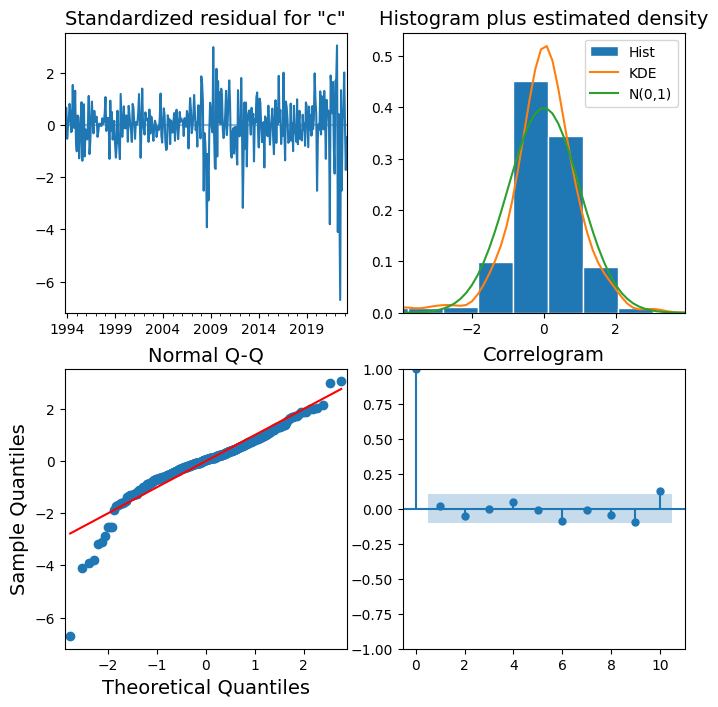

In [98]:
#Create diagnostic plots
results.plot_diagnostics(figsize=(8,8))
plt.show()

All four plots show that the SARIMA model fits the time series well

##SARIMA Prediction

Now we'll build a vector to hold the forecasts

In [99]:
prediction = results.get_prediction(start=-54)
mean_prediction=prediction.predicted_mean
mean_prediction = mean_prediction.rename("prediction")

Furthermore, we obtain confidence intervals from the sarima prediction

In [100]:
confi_int_p=prediction.conf_int()
lower_limits_p=confi_int_p.iloc[:,0]
upper_limits_p=confi_int_p.iloc[:,1]

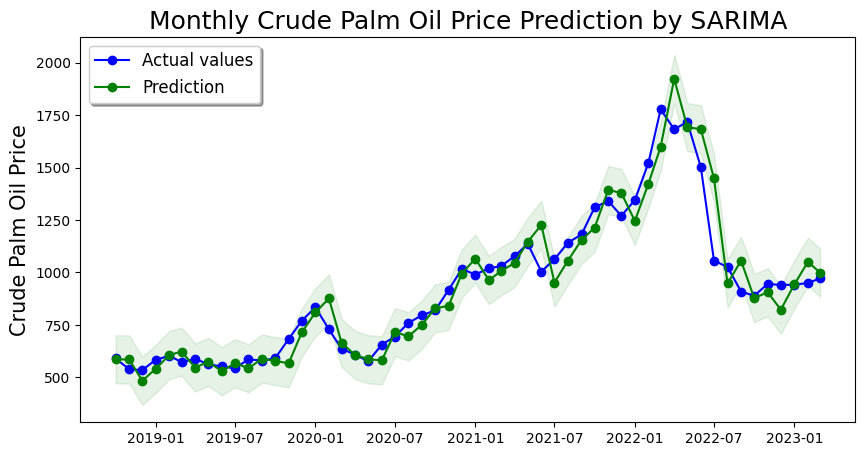

In [132]:
plt.figure(figsize=(10,5))
plt.title("Monthly Crude Palm Oil Price Prediction by SARIMA", fontsize=18)

plt.plot(df[-54:].index,df[-54:].values, label='Actual values', color="blue", marker="o")

plt.plot(mean_prediction[-54:].index, mean_prediction[-54:].values,label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction[-54:].index, lower_limits_p, upper_limits_p, alpha=0.1, color="green")

plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Crude Palm Oil Price', fontsize=15)
plt.show()

####SARIMA Performance Measure

In [111]:
mape_sarima = mape(df.iloc[-54:,0],mean_prediction)
print(f"MAPE OF SARIMA : {mape_sarima:.2f} %")

MAPE OF SARIMA : 0.07 %


In [112]:
rmse_sarima = sqrt(mean_squared_error(df[-54:].values,mean_prediction.values))
print(f"RMSE OF SARIMA MODEL : {rmse_sarima:.2f}")

RMSE OF SARIMA MODEL : 98.80


In [107]:
mse_sarima = mean_squared_error(df[-54:].values,mean_prediction.values)
print(f"MSE OF SARIMA MODEL : {mse_sarima:.2f}")

MSE OF SARIMA MODEL : 9762.41


In [115]:
mae_sarima = mean_absolute_error(df[-54:].values,mean_prediction.values)
print(f"MAE OF SARIMA MODEL : {mae_sarima:.2f}")

MAE OF SARIMA MODEL : 68.47


##SARIMA Forecast

In [84]:
# Create ARIMA forecast of next 10 values
forecast = results.get_forecast(steps=12)
mean_forecast=forecast.predicted_mean
mean_forecast = mean_forecast.rename("prediction")

In [85]:
confi_int_f=forecast.conf_int()
lower_limits_f=confi_int_f.iloc[:,0]
upper_limits_f=confi_int_f.iloc[:,1]

In [88]:
df_sarimax = mean_prediction.append(mean_forecast)

####Results Summary

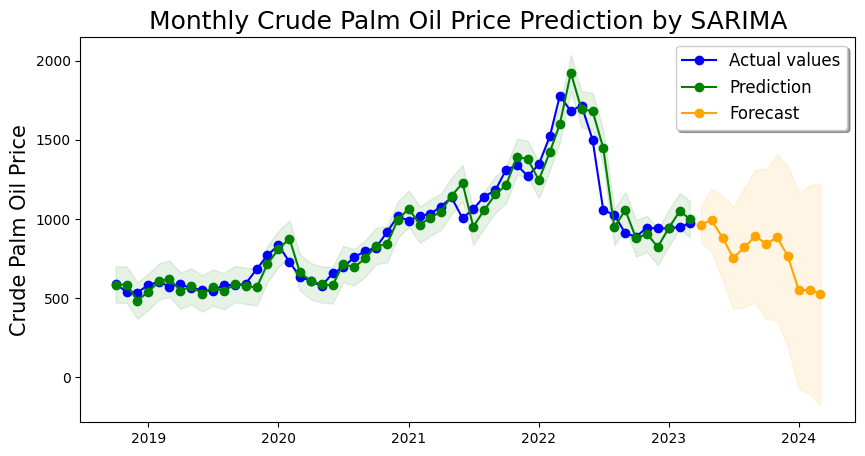

In [134]:
plt.figure(figsize=(10,5))
plt.title("Monthly Crude Palm Oil Price Prediction by SARIMA", fontsize=18)

plt.plot(df[-54:].index,df[-54:].values, label='Actual values', color="blue", marker="o")

plt.plot(mean_prediction[-54:].index, mean_prediction[-54:].values,label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction[-54:].index, lower_limits_p, upper_limits_p, alpha=0.1, color="green")

plt.plot(mean_forecast[-54:].index,mean_forecast[-54:].values, label='Forecast', color="orange", marker="o")
plt.fill_between(mean_forecast[-54:].index, lower_limits_f, upper_limits_f, alpha=0.1, color="orange")

#plt.axvline(df_pred.index[-1], color="red", linestyle="--")
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Crude Palm Oil Price', fontsize=15)
plt.show()